### a demo

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
import time

from matplotlib import pyplot as plt 
from pyvis.network import Network
from selenium import webdriver
from selenium.webdriver.common.by import By

In [2]:
GrandURL = "https://fireemblemwiki.org/wiki/Category:Lists_of_supports"
link_template = "List of supports in Fire Emblem"

In [3]:
# Open a webpage in Firefox, find all links of interest

driver = webdriver.Firefox()
driver.get(GrandURL)

time.sleep(3) # Let the page load
content = driver.find_elements(By.PARTIAL_LINK_TEXT, link_template)

In [4]:
# In example:

content[3].get_attribute('href')

'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'

### The games we wish to create graphs for are not listed in a neat order by release date on the webpage.

### We are also only interested in making graphs for certain games.

### We take a few steps to sort extract the info we need from the games we want.

In [5]:
run = 0
for game in content:
    print(run, game.text)
    run+=1

0 List of supports in Fire Emblem Awakening
1 List of supports in Fire Emblem: The Binding Blade
2 List of supports in Fire Emblem: The Blazing Blade
3 List of supports in Fire Emblem Echoes: Shadows of Valentia
4 List of supports in Fire Emblem Engage
5 List of supports in Fire Emblem Fates
6 List of supports in Fire Emblem: Path of Radiance
7 List of supports in Fire Emblem: The Sacred Stones
8 List of supports in Fire Emblem: Three Houses
9 List of supports in Fire Emblem Warriors
10 List of supports in Fire Emblem Warriors: Three Hopes


In [6]:
GamesOfInterest = {
    "FE6" : 1,
    "FE7" : 2,
    "FE8" : 7,
    "FE9" : 6,
    "FE15" : 3,
    "FE16" : 8,
    "FE17" : 4
}

game_page_links =[]
for v in GamesOfInterest.values():
    game_title = content[v].text
    game_title = game_title.split(link_template)[1]
    game_title = game_title[game_title.find(" ")+1:]
    
    game_link = content[v].get_attribute('href')
    game_page_links.append(
        {"game_title": game_title, "url": game_link}
    )

In [7]:
game_page_links

[{'game_title': 'The Binding Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Binding_Blade'},
 {'game_title': 'The Blazing Blade',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Blazing_Blade'},
 {'game_title': 'The Sacred Stones',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_The_Sacred_Stones'},
 {'game_title': 'Path of Radiance',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Path_of_Radiance'},
 {'game_title': 'Echoes: Shadows of Valentia',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Echoes:_Shadows_of_Valentia'},
 {'game_title': 'Three Houses',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem:_Three_Houses'},
 {'game_title': 'Engage',
  'url': 'https://fireemblemwiki.org/wiki/List_of_supports_in_Fire_Emblem_Engage'}]

### We start with FE6: The Binding Blade

In [8]:
# The lxml optional dependancy is required
# !pip install lxml

support_table = pd.read_html(game_page_links[0]['url'])
support_table = support_table[1]
support_table = support_table.T
support_table.columns = support_table.iloc[0]
support_table = support_table.drop("Character")
support_table

Character,Roy,Marcus,Alen,Lance,Wolt,Bors,Elen,Dieck,Ward,Lot,...,Garret,Fae,Hugh,Zeiss,Douglas,Niime,Juno,Dayan,Yoder,Karel
1,Marcus,Roy,Roy,Roy,Roy,Astolfo,Chad,Ward,Alen,Lance,...,Lilina,Sue,Chad,Elen,Geese,Raigh,Shanna,Rutger,Saul,Rutger
2,Alen,Alen,Marcus,Marcus,Marcus,Lilina,Lugh,Lot,Dieck,Dieck,...,Geese,Elffin,Lugh,Sin,Larum,Sophia,Zelot,Sue,Dorothy,Noah
3,Lance,Lance,Lance,Alen,Alen,Barthe,Saul,Shanna,Lot,Ward,...,Gonzalez,Sophia,Raigh,Bartre,Elffin,Fae,Trec,Sin,Melady,Fir
4,Wolt,Wolt,Wolt,Wolt,Lance,Ogier,Melady,Clarine,Shanna,Shanna,...,Larum,Igrene,Cath,Melady,Cecilia,Hugh,Noah,Gonzalez,Niime,Bartre
5,Shanna,Lilina,Ward,Lot,Sue,Gwendolyn,Zeiss,Rutger,Echidna,Echidna,...,Cath,Niime,Niime,Karel,Igrene,Yoder,Thea,Yoder,Dayan,Zeiss
6,Sue,--,Thea,Clarine,--,--,--,Klein,--,--,...,--,--,--,--,Perceval,--,--,--,--,--
7,Lilina,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
8,Larum,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
9,Cecilia,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--
10,Sophia,--,--,--,--,--,--,--,--,--,...,--,--,--,--,--,--,--,--,--,--


In [9]:
# To create a graph, we need source nodes and target nodes.
# For example, (Roy, Marcus), where Roy is the source and Marcus is the target. 
# To make the keys unique, we use the template (Marcus, Roy) for all of Roy's supports.

individual_supports = []
for character in support_table.columns:
    for friend in support_table[character]:
        if friend != "--":
            individual_supports.append({"Source": character, "Target": friend})

individual_supports = pd.DataFrame(individual_supports)

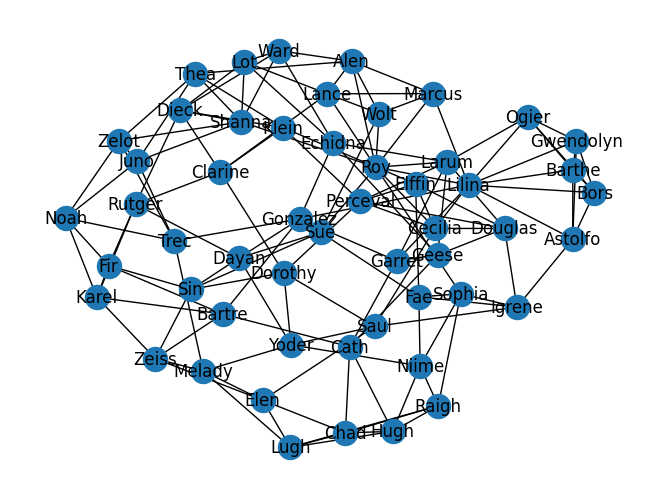

In [10]:
FE6_graph = nx.from_pandas_edgelist(individual_supports,
                                    source="Source", target="Target",
                                    create_using=nx.Graph())
pos = nx.kamada_kawai_layout(FE6_graph)
nx.draw(FE6_graph, with_labels=True, pos=pos)
#plt.show()

In [11]:
node_degree = dict(FE6_graph.degree)
degree_dict = nx.degree_centrality(FE6_graph)
betweenness_dict = nx.betweenness_centrality(FE6_graph)
closeness_dict = nx.closeness_centrality(FE6_graph)

nx.set_node_attributes(FE6_graph, node_degree, 'size')
nx.set_node_attributes(FE6_graph, degree_dict, 'degree_centrality')
nx.set_node_attributes(FE6_graph, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(FE6_graph, closeness_dict, 'closeness_centrality')

communities = community_louvain.best_partition(FE6_graph)
nx.set_node_attributes(FE6_graph, communities, 'group')

In [ ]:
net = Network(notebook=True, width="800px", height="800px",cdn_resources='remote')
net.from_nx(FE6_graph)
net.show("FE6.html")